# Model Evaluation - Neural Network

- Alejandro Hohmann
- Bhanu Muvva
- Chunxia Tong

The purpose of this notebook is to use NN. It does not yet use the new features.

# Table of Contents

### - [Neural Net](#NN)

### - [Neural Net with Staley Cross Products](#staley)

### - [Similar Architecture but with only one dropout layer](#dropout)

In [1]:
# assign seed now for consistency any time it needs to be used
seed=27

In [2]:
# file structure libraries
import numpy as np
import pandas as pd
import os

# # visualization libraries
from matplotlib import pyplot as plt
# plt.style.use('bmh')
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# Have plots display in notebook
%matplotlib inline
# import seaborn as sns

# # ML libraries
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix

# # for sigmoid function, in case we need to manually implement in LR
# from scipy.stats import logistic

import torch
import torch.nn as nn
import torch.optim as optim

## Neural Net <a id="NN">

### TASK LIST
- Add performance metrics such as Jaccard, F1 score and AUC score (scikit-learn) to compare the performance of your NN to Staley’s values and those of our previous work.

- The data preparation notebooks I pushed to the repository contain more processing steps including a train-test split on a site basis and randomization of precipitation values which I found helpful. I recommend you use these steps as well.

In [3]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate) # dropout to prevent overfitting

        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # output to probability rather than bool
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        
        out = self.fc5(out)
        out = self.sigmoid(out)      

        return out

In [26]:
# # can't really compare loss between different loss-functions

Training loss: 0.45390358567237854
Validation loss: 0.4234210252761841


Training accuracy: 0.7545871559633027
Test accuracy: 0.7579908675799086


F1 Score (test): 0.273972602739726


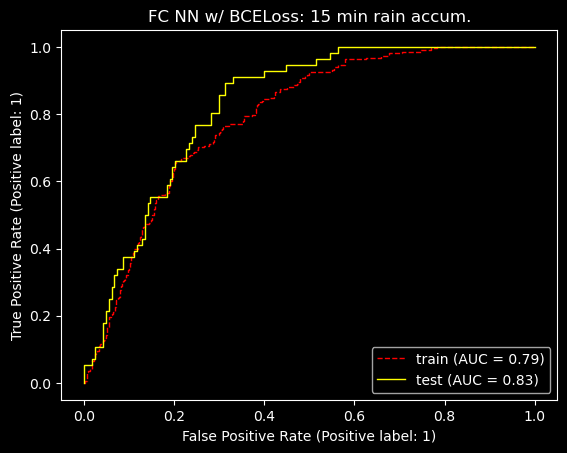

In [4]:
# 15 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('../../data/ofr20161106-na-omit-feat-15.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 100
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
#y_train_prob = torch.sigmoid(y_train_pred) # already a probability

y_test_pred = model(X_test)
# y_test_prob = torch.sigmoid(y_test_pred) # already a probability

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')
# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(),
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 15 min rain accum.');

Training loss: 0.4480169415473938
Validation loss: 0.41056084632873535


Training accuracy: 0.7660550458715596
Test accuracy: 0.771689497716895


F1 Score (test): 0.4444444444444445


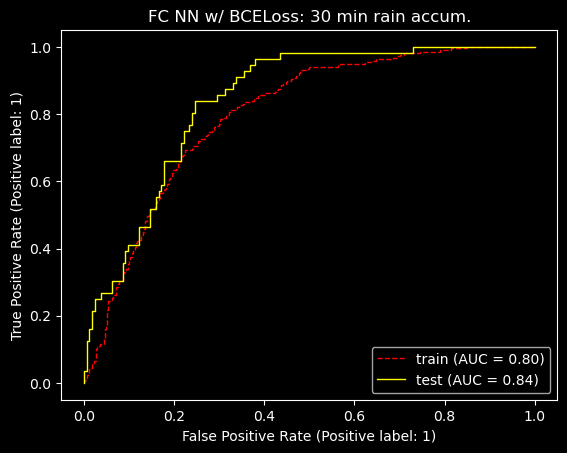

In [5]:
# 30 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('../../data/ofr20161106-na-omit-feat-30.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 100
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')
# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 30 min rain accum.');

Training loss: 0.4553177058696747
Validation loss: 0.41788220405578613


Training accuracy: 0.768348623853211
Test accuracy: 0.7945205479452054


F1 Score (test): 0.5454545454545454


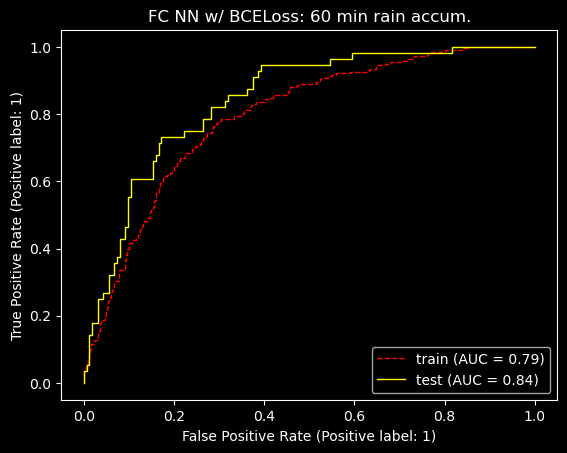

In [6]:
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('../../data/ofr20161106-na-omit-feat-60.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 100
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
#torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum.');

Training loss: 0.35938405990600586
Validation loss: 0.378680020570755


Training accuracy: 0.8073394495412844
Test accuracy: 0.8082191780821918


F1 Score (test): 0.6379310344827587


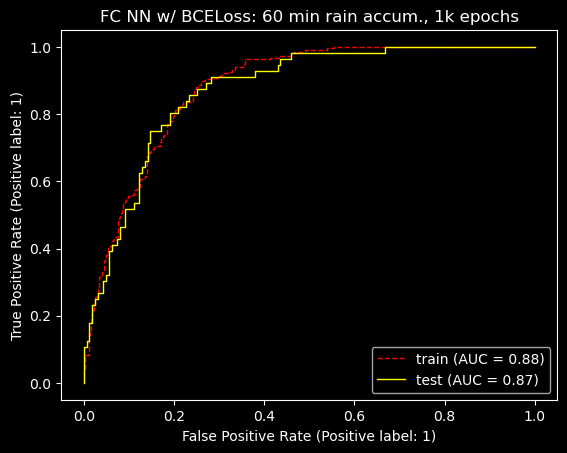

In [7]:
# 10x the num epochs

# 60 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('../../data/ofr20161106-na-omit-feat-60.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 1000
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
#torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum., 1k epochs');

## Use Staley cross product features <a id="staley">
- swapped out 15 min rain accumulation for 60 min rain accumulation

In [8]:
staley_data = pd.read_csv("../../data/ofr20161106-na-omit.csv")

#computing input data similar to Staley'16
staley_data["PropHM23_x_i60"] = staley_data["PropHM23"] * staley_data["Acc060_mm"]
staley_data["dNBR_x_i60"] = staley_data["dNBR/1000"] * staley_data["Acc060_mm"]
staley_data["KF_x_i60"] = staley_data["KF"] * staley_data["Acc060_mm"]

use_cols=["PropHM23_x_i60",
          "dNBR_x_i60", 
          "KF_x_i60",
          "Response",
         ]
staley_data = staley_data[use_cols]
staley_data

PropHM23_x_i60  dNBR_x_i60  KF_x_i60  Response
0           0.435865    0.595706  0.500000         0
1           0.122497    0.449791  0.500000         0
2           0.085936    0.131075  0.497081         0
3           0.073732    0.113369  0.200000         0
4           0.046682    0.168126  0.200000         0
...              ...         ...       ...       ...
1086        2.604307   14.558344  0.000000         0
1087        4.519721   23.562891  0.000000         0
1088        4.391669   16.699955  0.000000         1
1089        0.382221    7.295049  0.000000         1
1090        0.061260   19.508695  0.000000         0

[1091 rows x 4 columns]

In [9]:
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = staley_data.copy()
    X = data.iloc[:, :3] # input features
    y = data.iloc[:, 3] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 1000
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
#torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum. and crossproduct features');

Training loss: 0.19791069626808167
Validation loss: 0.8535751104354858


Training accuracy: 0.9059633027522935
Test accuracy: 0.7579908675799086


F1 Score (test): 0.5225225225225225


# dropout only once <a id="dropout">

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate) # dropout to prevent overfitting
        
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.relu4 = nn.ReLU()
        
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid() # output to probability rather than bool
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        out = self.relu3(out)
        
        out = self.fc4(out)
        out = self.relu4(out)
        
        out = self.fc5(out)
        out = self.sigmoid(out)      

        return out

In [11]:
# 60 MIN
if __name__ == '__main__':
    # Load data
    data = pd.read_csv('../../data/ofr20161106-na-omit-feat-60.csv')
    X = data.iloc[:, :4] # input features
    y = data.iloc[:, 4] # debris flow bool
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train = torch.tensor(X_train.values).float()
    y_train = torch.tensor(y_train.values).float().view(-1, 1)
    X_test = torch.tensor(X_test.values).float()
    y_test = torch.tensor(y_test.values).float().view(-1, 1)
     
    input_size = X_train.shape[1]
    hidden_size = 500
    output_size = 1
    dropout_rate = 0.2  
    learning_rate = 0.001 # 0.001 is default value for Adam optimizer
    
    model = Net(input_size, hidden_size, output_size, dropout_rate)
    
    # criterion = nn.MSELoss() 
    criterion = nn.BCELoss()  # cross-entropy better suited for binary classification than MSE
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([output_size]))
    #criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
    num_epochs = 1000
    
    for epoch in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   
    
#torch.save(model.state_dict(), 'model.pth')    
y_train_pred = model(X_train)
y_train_prob = torch.sigmoid(y_train_pred)

y_test_pred = model(X_test)
y_test_prob = torch.sigmoid(y_test_pred)

train_loss = criterion(y_train_pred, y_train)
val_loss = criterion(y_test_pred, y_test)

print(f'Training loss: {train_loss}')
print(f'Validation loss: {val_loss}')

print("\n")

# accuracy
train_pred_correct = sum(y_train.detach().numpy() == np.round(y_train_pred.detach().numpy()))
train_accuracy = (train_pred_correct / y_train.shape[0])[0]
print(f'Training accuracy: {train_accuracy}')

test_pred_correct = sum(y_test.detach().numpy() == np.round(y_test_pred.detach().numpy()))
test_accuracy = (test_pred_correct / y_test.shape[0])[0]
print(f'Test accuracy: {test_accuracy}')

# f1
f1_output = f1_score(y_test, np.round(y_test_pred.detach().numpy()))
print("\n")
print(f'F1 Score (test): {f1_output}')

# plot AUC
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train.detach().numpy(), 
                                 y_train_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='red', 
                                 name='train', 
                                 linestyle="dashed"
                                );

RocCurveDisplay.from_predictions(y_test.detach().numpy(), 
                                 y_test_pred.detach().numpy(), 
                                 ax=ax, 
                                 linewidth=1, 
                                 color='yellow', 
                                 name='test');

plt.title('FC NN w/ BCELoss: 60 min rain accum, single dropout');

Training loss: 0.3423537015914917
Validation loss: 0.37273186445236206


Training accuracy: 0.8073394495412844
Test accuracy: 0.817351598173516


F1 Score (test): 0.5652173913043479
